In [1]:
import pandas as pd
import numpy as np
import os
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as L
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Check if TensorFlow is using a GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2025-11-03 15:29:47.913447: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762183788.107600      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762183788.163394      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Num GPUs Available:  1


In [2]:
# Data processing functions
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

def zcr(data, frame_length, hop_length):
    zcr = librosa.feature.zero_crossing_rate(data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)

def rmse(data, frame_length=2048, hop_length=512):
    # Updated to match the newer librosa version
    rms = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rms)

def mfcc(data, sr, frame_length=2048, hop_length=512, flatten=True):
    mfcc = librosa.feature.mfcc(y=data, sr=sr)
    return np.squeeze(mfcc.T) if not flatten else np.ravel(mfcc.T)

def extract_features(data, sr=22050, frame_length=2048, hop_length=512):
    result = np.array([])
    result = np.hstack((result, zcr(data, frame_length, hop_length), rmse(data, frame_length, hop_length), mfcc(data, sr, frame_length, hop_length)))
    return result

def get_features(path, duration=2.5, offset=0.6):
    data, sr = librosa.load(path, duration=duration, offset=offset)
    aud = extract_features(data)
    audio = np.array(aud)
    
    noised_audio = noise(data)
    aud2 = extract_features(noised_audio)
    audio = np.vstack((audio, aud2))
    
    pitched_audio = pitch(data, sr)
    aud3 = extract_features(pitched_audio)
    audio = np.vstack((audio, aud3))
    
    pitched_noised_audio = noise(pitch(data, sr))
    aud4 = extract_features(pitched_noised_audio)
    audio = np.vstack((audio, aud4))
    
    return audio

In [6]:
# Prepare data
ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
Crema = "/kaggle/input/cremad/AudioWAV/"
Tess = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"

In [7]:
def process_datasets():
    # Process RAVDESS dataset
    ravdess_directory_list = os.listdir(ravdess)
    file_emotion = []
    file_path = []
    for i in ravdess_directory_list:
        actor = os.listdir(ravdess + i)
        for f in actor:
            part = f.split('.')[0].split('-')
            file_emotion.append(int(part[2]))
            file_path.append(ravdess + i + '/' + f)
    emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
    path_df = pd.DataFrame(file_path, columns=['Path'])
    ravdess_df = pd.concat([emotion_df, path_df], axis=1)
    ravdess_df.Emotions.replace({1: 'neutral', 2: 'neutral', 3: 'happy', 4: 'sad', 5: 'angry', 6: 'fear', 7: 'disgust', 8: 'surprise'}, inplace=True)
    
    # Process CREMA-D dataset
    crema_directory_list = os.listdir(Crema)
    file_emotion = []
    file_path = []
    for file in crema_directory_list:
        file_path.append(Crema + file)
        part = file.split('_')
        if part[2] == 'SAD':
            file_emotion.append('sad')
        elif part[2] == 'ANG':
            file_emotion.append('angry')
        elif part[2] == 'DIS':
            file_emotion.append('disgust')
        elif part[2] == 'FEA':
            file_emotion.append('fear')
        elif part[2] == 'HAP':
            file_emotion.append('happy')
        elif part[2] == 'NEU':
            file_emotion.append('neutral')
        else:
            file_emotion.append('Unknown')
    emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
    path_df = pd.DataFrame(file_path, columns=['Path'])
    crema_df = pd.concat([emotion_df, path_df], axis=1)
    
    # Process TESS dataset
    tess_directory_list = os.listdir(Tess)
    file_emotion = []
    file_path = []
    for dir in tess_directory_list:
        directories = os.listdir(Tess + dir)
        for file in directories:
            part = file.split('.')[0].split('_')[2]
            if part == 'ps':
                file_emotion.append('surprise')
            else:
                file_emotion.append(part)
            file_path.append(Tess + dir + '/' + file)
    emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
    path_df = pd.DataFrame(file_path, columns=['Path'])
    tess_df = pd.concat([emotion_df, path_df], axis=1)
    
    # Process SAVEE dataset
    savee_directory_list = os.listdir(Savee)
    file_emotion = []
    file_path = []
    for file in savee_directory_list:
        file_path.append(Savee + file)
        part = file.split('_')[1]
        ele = part[:-6]
        if ele == 'a':
            file_emotion.append('angry')
        elif ele == 'd':
            file_emotion.append('disgust')
        elif ele == 'f':
            file_emotion.append('fear')
        elif ele == 'h':
            file_emotion.append('happy')
        elif ele == 'n':
            file_emotion.append('neutral')
        elif ele == 'sa':
            file_emotion.append('sad')
        else:
            file_emotion.append('surprise')
    emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
    path_df = pd.DataFrame(file_path, columns=['Path'])
    savee_df = pd.concat([emotion_df, path_df], axis=1)
    
    # Combine all dataframes
    data_path = pd.concat([ravdess_df, crema_df, tess_df, savee_df], axis=0)
    return data_path

In [8]:
data_path = process_datasets()

/tmp/ipykernel_37/3421611117.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ravdess_df.Emotions.replace({1: 'neutral', 2: 'neutral', 3: 'happy', 4: 'sad', 5: 'angry', 6: 'fear', 7: 'disgust', 8: 'surprise'}, inplace=True)


In [9]:
# Extract features and labels
X, Y = [], []
for path, emotion in zip(data_path['Path'], data_path['Emotions']):
    features = get_features(path)
    for i in features:
        X.append(i)
        Y.append(emotion)

In [10]:
len(X), len(Y), data_path.Path.shape

(48648, 48648, (12162,))

In [11]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion.csv', index=False)
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.343750,0.479492,0.573730,0.458008,0.375488,0.301758,0.269043,0.255371,0.251465,0.251953,...,-1.517691,-1.716481,-1.599312,-1.234615,-0.693200,-0.038981,0.675205,1.405603,2.112302,surprise
1,0.251953,0.385742,0.491211,0.449219,0.392090,0.326172,0.288086,0.270996,0.270020,0.269531,...,-3.767890,1.041078,0.479081,0.808412,-2.156868,-2.480438,-2.108992,-2.248855,3.719246,surprise
2,0.304199,0.427246,0.540039,0.471191,0.387207,0.333008,0.282227,0.259277,0.258789,0.252930,...,0.518303,0.838667,1.308736,1.855117,2.405196,2.896454,3.283496,3.541684,3.667480,surprise
3,0.260254,0.384766,0.506836,0.488770,0.480469,0.478027,0.481934,0.489258,0.492188,0.488770,...,-1.335641,0.516775,2.949794,-1.597457,0.319345,-1.787609,-1.367854,1.648347,2.769778,surprise
4,0.437500,0.659668,0.862305,0.878906,0.865234,0.847168,0.845703,0.827637,0.835938,0.667969,...,2.586420,2.746858,2.223281,0.986924,-0.730691,-2.530884,-4.002835,-4.849377,-4.929749,neutral


In [17]:
Emotions = pd.read_csv('/kaggle/working/emotion.csv')
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.343750,0.479492,0.573730,0.458008,0.375488,0.301758,0.269043,0.255371,0.251465,0.251953,...,-1.517691,-1.716481,-1.599312,-1.234615,-0.693200,-0.038981,0.675205,1.405603,2.112302,surprise
1,0.251953,0.385742,0.491211,0.449219,0.392090,0.326172,0.288086,0.270996,0.270020,0.269531,...,-3.767890,1.041078,0.479081,0.808412,-2.156868,-2.480438,-2.108992,-2.248855,3.719246,surprise
2,0.304199,0.427246,0.540039,0.471191,0.387207,0.333008,0.282227,0.259277,0.258789,0.252930,...,0.518303,0.838667,1.308736,1.855117,2.405196,2.896454,3.283496,3.541684,3.667480,surprise
3,0.260254,0.384766,0.506836,0.488770,0.480469,0.478027,0.481934,0.489258,0.492188,0.488770,...,-1.335641,0.516775,2.949794,-1.597457,0.319345,-1.787609,-1.367854,1.648347,2.769778,surprise
4,0.437500,0.659668,0.862305,0.878906,0.865234,0.847168,0.845703,0.827637,0.835938,0.667969,...,2.586420,2.746858,2.223281,0.986924,-0.730691,-2.530884,-4.002835,-4.849377,-4.929749,neutral


In [18]:
Emotions=Emotions.fillna(0)
print(Emotions.isna().any())
Emotions.shape

0           False
1           False
2           False
3           False
4           False
            ...  
2372        False
2373        False
2374        False
2375        False
Emotions    False
Length: 2377, dtype: bool


(48648, 2377)

In [19]:
X = Emotions.iloc[: ,:-1].values
Y = Emotions['Emotions'].values

In [20]:
# One-hot encode the labels
encoder = OneHotEncoder()
Y = encoder.fit_transform(Y.reshape(-1, 1)).toarray()

In [21]:
# Split the dataset
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=0.2, shuffle=True)

In [22]:
# Standardize the data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [23]:
import numpy as np

# Save the array
np.save('x_train.npy', x_train)

In [24]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((38918, 2376), (38918, 7), (9730, 2376), (9730, 7))

In [25]:
# Reshape the data for Conv1D (CNN) input
x_traincnn = np.expand_dims(x_train, axis=2)
x_testcnn = np.expand_dims(x_test, axis=2)

In [26]:
# Define the CNN model
model = tf.keras.Sequential([
    L.Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_traincnn.shape[1], 1)),
    L.BatchNormalization(),
    L.MaxPooling1D(pool_size=5, strides=2, padding='same'),

    L.Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'),
    L.BatchNormalization(),
    L.MaxPooling1D(pool_size=5, strides=2, padding='same'),
    L.Dropout(0.2),

    L.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'),
    L.BatchNormalization(),
    L.MaxPooling1D(pool_size=5, strides=2, padding='same'),

    L.Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu'),
    L.BatchNormalization(),
    L.MaxPooling1D(pool_size=5, strides=2, padding='same'),
    L.Dropout(0.2),

    L.Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'),
    L.BatchNormalization(),
    L.MaxPooling1D(pool_size=3, strides=2, padding='same'),
    L.Dropout(0.2),

    L.Flatten(),
    L.Dense(512, activation='relu'),
    L.BatchNormalization(),
    L.Dense(7, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1762186604.846623      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [27]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
# Callbacks
model_checkpoint = ModelCheckpoint('best_model1_weights.keras', monitor='val_accuracy', save_best_only=True)
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

In [29]:
# Train the model
history = model.fit(x_traincnn, y_train, epochs=50, validation_data=(x_testcnn, y_test),
                    batch_size=64, callbacks=[model_checkpoint, early_stop, lr_reduction])

Epoch 1/50


I0000 00:00:1762186621.003752     167 service.cc:148] XLA service 0x7e3200002270 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762186621.004633     167 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1762186621.643510     167 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/609 ━━━━━━━━━━━━━━━━━━━━ 2:44:11 16s/step - accuracy: 0.1406 - loss: 2.5976

I0000 00:00:1762186631.082767     167 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


609/609 ━━━━━━━━━━━━━━━━━━━━ 108s 150ms/step - accuracy: 0.4060 - loss: 1.6395 - val_accuracy: 0.3893 - val_loss: 1.6420 - learning_rate: 0.0010
Epoch 2/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 83s 136ms/step - accuracy: 0.5549 - loss: 1.1504 - val_accuracy: 0.5266 - val_loss: 1.2331 - learning_rate: 0.0010
Epoch 3/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 83s 136ms/step - accuracy: 0.6067 - loss: 1.0171 - val_accuracy: 0.5928 - val_loss: 1.0527 - learning_rate: 0.0010
Epoch 4/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 83s 136ms/step - accuracy: 0.6461 - loss: 0.9227 - val_accuracy: 0.6173 - val_loss: 1.0207 - learning_rate: 0.0010
Epoch 5/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 83s 136ms/step - accuracy: 0.7028 - loss: 0.7834 - val_accuracy: 0.6390 - val_loss: 0.9519 - learning_rate: 0.0010
Epoch 6/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 83s 136ms/step - accuracy: 0.7499 - loss: 0.6700 - val_accuracy: 0.6968 - val_loss: 0.8103 - learning_rate: 0.0010
Epoch 7/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 83s 136ms/step - accuracy: 0.8066 - loss

In [30]:
# Save the entire model to HDF5
model.save('emotion_recognition_model.h5')

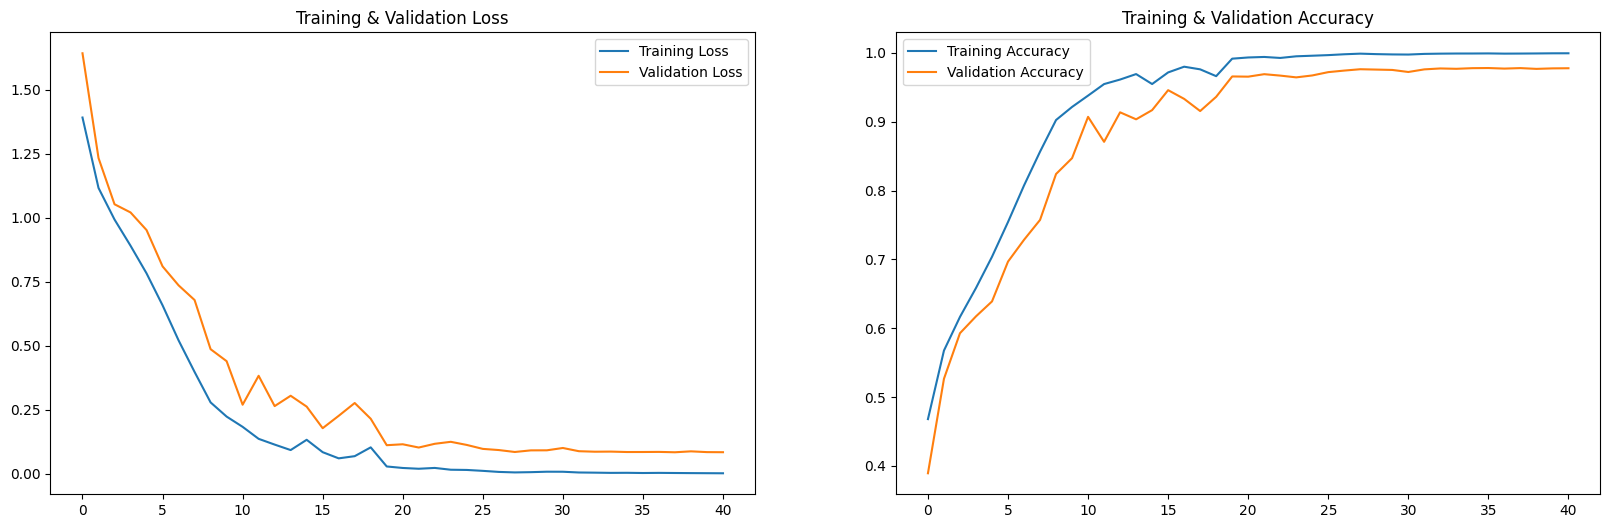

In [31]:
# Plot training history
epochs = range(len(history.history['accuracy']))
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.show()

In [37]:
from sklearn.metrics import classification_report

# Evaluate on test data
test_loss, test_acc = model.evaluate(x_testcnn, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
# Predict on the test set
y_pred = model.predict(x_testcnn)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate the classification report
report = classification_report(y_true, y_pred, target_names=encoder.categories_[0])
print(report)

305/305 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9780 - loss: 0.0835
Test Accuracy: 97.80%
305/305 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
              precision    recall  f1-score   support

       angry       0.98      0.98      0.98      1484
     disgust       0.98      0.97      0.97      1558
        fear       0.98      0.98      0.98      1505
       happy       0.97      0.97      0.97      1619
     neutral       0.98      0.98      0.98      1558
         sad       0.98      0.99      0.99      1478
    surprise       0.98      0.98      0.98       528

    accuracy                           0.98      9730
   macro avg       0.98      0.98      0.98      9730
weighted avg       0.98      0.98      0.98      9730

